In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Prediction of Closing Price of Stock LSTM
The goal is to predict the Closing Price behavior of four companies by predicting `n` coming days (`forward_days`), using as input the `m` past days (`look_back`).

### (Prevendo o preço de uma ação no mercado de ações)
O objetivo é prever o que acontecerá com o valor de fechamento de quatro ações em `n` dias (`forward_days`), tendo como base os `m` dias anteriores (`look_back`).

In [2]:
num_companies = 4
look_back = 40
forward_days = 10
num_periods = 20

companies_names = ['A', 'B', 'C', 'D']
colors = ['r','g','c','m','y','k','w','b'] #from matplotlib

First, just open the CSV using Pandas, set the Date as index and keep only the Closing Price column.

Primeiro, vamos abrir o CSV com o Pandas, colocar as datas como index e manter apenas a coluna que queremos prever, que é o preço de fechamento.

In [3]:
df_A = pd.read_csv('data/company_A.csv')
df_A['Date'] = pd.to_datetime(df_A['Date'])

df_B = pd.read_csv('data/company_B.csv')
df_B['Date'] = pd.to_datetime(df_B['Date'])

df_C = pd.read_csv('data/company_C.csv')
df_C['Date'] = pd.to_datetime(df_C['Date'])

df_D = pd.read_csv('data/company_D.csv')
df_D['Date'] = pd.to_datetime(df_D['Date'])

Note: make sure the all the dates in each and every df are the same. (In this dataset, they are)

In [4]:
companies = [df_A, df_B, df_C, df_D]

for comapany in companies:
    comapany.set_index('Date', inplace=True)
    comapany.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [5]:
df_A.tail()

,Close
Date,
2018-12-31,157.740005
2019-01-02,157.919998
2019-01-03,142.190002
2019-01-04,148.259995
2019-01-07,147.929993


In [6]:
df_B.head()

,Close
Date,
2010-01-08,30.660000
2010-01-11,30.270000
2010-01-12,30.070000
2010-01-13,30.350000
2010-01-14,30.959999


In [7]:
print(len(df_A))
print(len(df_B))
print(len(df_C))
print(len(df_D))

2264
2264
2264
2264


### Data visualization ( Vizualizando os dados )

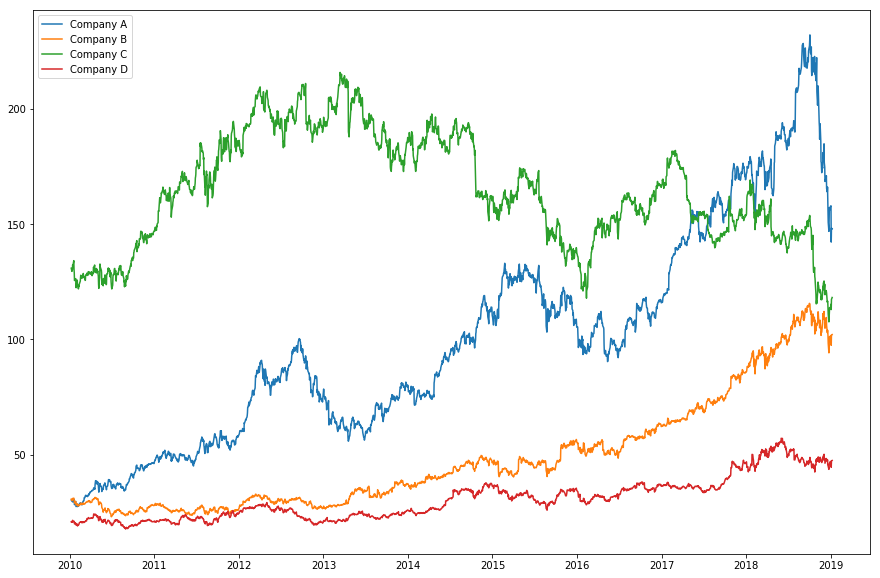

In [8]:
plt.figure(figsize = (15,10))

plt.plot(df_A, label='Company A')
plt.plot(df_B, label='Company B')
plt.plot(df_C, label='Company C')
plt.plot(df_D, label='Company D')

plt.legend(loc='best')
plt.show()

### Data normalization ( Normalizando os dados )

In [9]:
scl = MinMaxScaler()
    
args = [company.values.reshape(company.shape[0],1) for company in companies]

In [10]:
array = scl.fit_transform(np.concatenate((args[0],args[1],args[2],args[3]), axis=1))

### Split all the data in two categories: Data to Train/Validate the LSTM and Data to Test the model
All this process is explained on the notebook: LSTM input and output.

In [11]:
#split in Train and Test
division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [12]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [13]:
X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days,num_companies)
y = np.array([list(x.ravel()) for x in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(1612, 40, 4)
(403, 40, 4)
(20, 40, 4)
(1612, 40)
(403, 40)
(20, 40)


## Train the LSTM (Treinando a LSTM)

In [15]:
#Optionaly, you can load a model
#model = load_model('Trained/several-companies/LSTM_LB40_FD10_E200_F100_S50.h5')
#If you do, don't reTrain or reSave it...

In [16]:
NUM_NEURONS_FirstLayer = 200
NUM_NEURONS_SecondLayer = 100
EPOCHS = 10 #

#Build the model
model = Sequential()

model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,num_companies), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days * num_companies))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=1, verbose=2)

Train on 1612 samples, validate on 403 samples
Epoch 1/10
 - 104s - loss: 0.0041 - val_loss: 0.0017
Epoch 2/10
 - 102s - loss: 0.0018 - val_loss: 0.0022
Epoch 3/10
 - 101s - loss: 0.0014 - val_loss: 0.0012
Epoch 4/10
 - 103s - loss: 0.0013 - val_loss: 0.0013
Epoch 5/10
 - 102s - loss: 0.0011 - val_loss: 9.1632e-04
Epoch 6/10
 - 114s - loss: 0.0011 - val_loss: 0.0010
Epoch 7/10
 - 122s - loss: 0.0011 - val_loss: 7.9954e-04
Epoch 8/10
 - 130s - loss: 9.9053e-04 - val_loss: 0.0014
Epoch 9/10
 - 138s - loss: 9.6906e-04 - val_loss: 8.3822e-04
Epoch 10/10
 - 126s - loss: 9.7845e-04 - val_loss: 0.0014


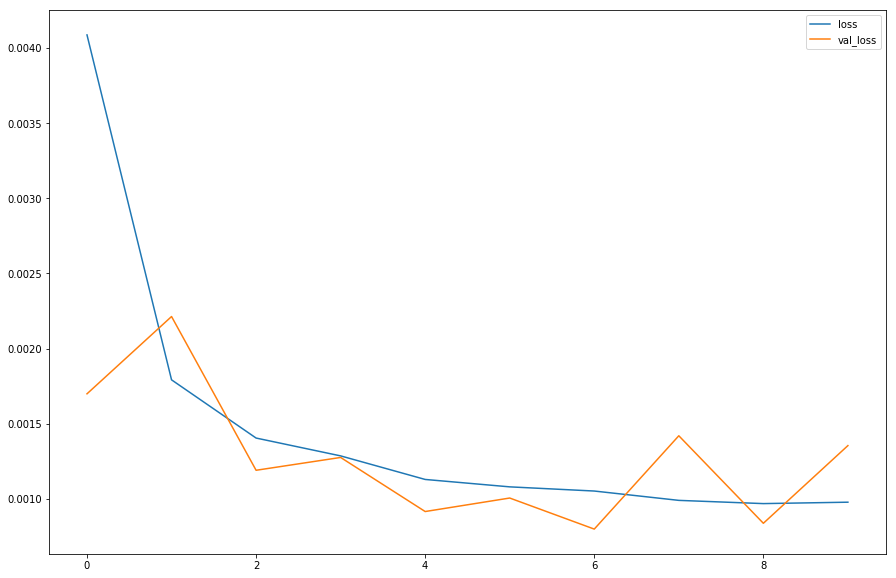

In [17]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [18]:
#Saving the model
file_name = 'LSTM_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_LB40_FD10_E10_F200_S100.h5` to disk


### Predicting the Test Set to see the results
This process is also explained on the notebook: LSTM input and output.


In [19]:
X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

Xt = model.predict(X_test)
Xt.shape

(20, 40)

In [20]:
def do_inverse_transform(output_result,num_companies = 4):
    #From input/output nootbook: apply makeup, use scl.inverse_transform and remove makeup
    
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scl.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [21]:
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [22]:
Xt = do_inverse_transform(Xt)

MP = prediction_by_step_by_company(Xt, num_companies)
MP.shape

(4, 20, 10)

In [23]:
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [24]:
Yt = do_inverse_transform(y_test)

MT = target_by_company(Yt, num_companies)
MT.shape

(4, 200)

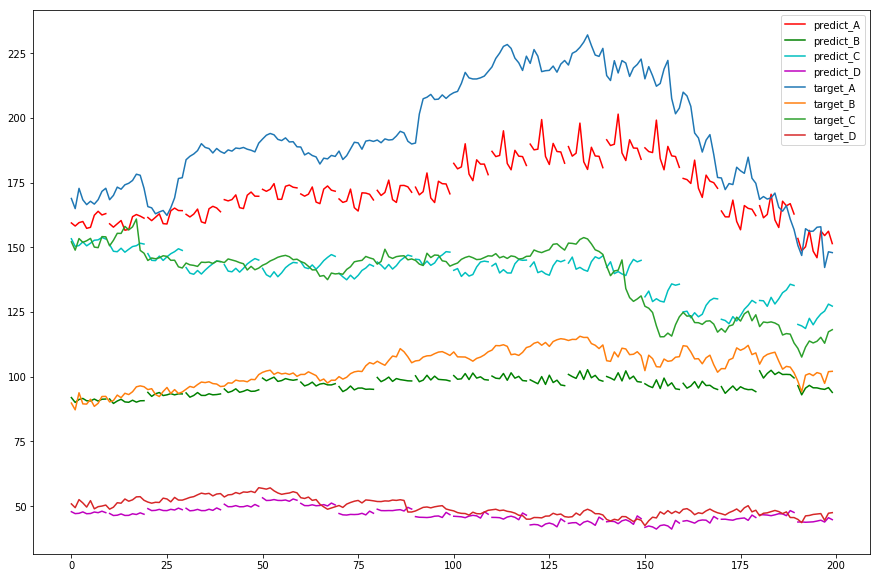

In [25]:
plt.figure(figsize = (15,10))

companies_to_show = [0,1,2,3] #select one of [0,1,2,3] to see only one


    
for id_company in companies_to_show:
    for i in range(0,len(MP[id_company])):
        plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
    plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(MT[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

### Predicting all the data to see how the model reacts to Train and Test set


In [26]:
X_all,y_all = processData(array,look_back,forward_days,num_companies,forward_days)
y_all = np.array([list(a.ravel()) for a in y_all])

In [27]:
Xt = model.predict(X_all)
Xt.shape

(222, 40)

In [28]:
Xt = do_inverse_transform(Xt)

MP = prediction_by_step_by_company(Xt, num_companies)
MP.shape

(4, 222, 10)

In [29]:
Yt = do_inverse_transform(y_all)

MT = target_by_company(Yt, num_companies)
MT.shape

(4, 2220)

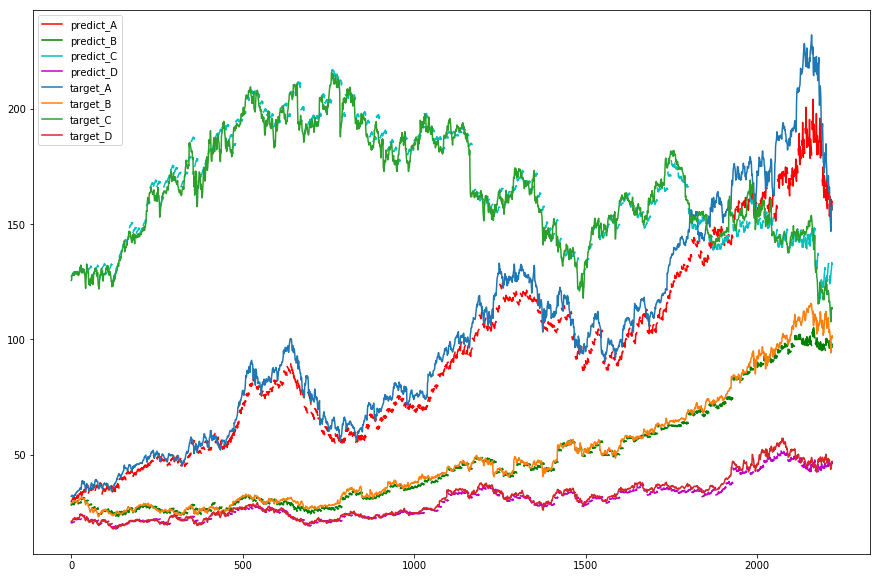

In [30]:
plt.figure(figsize = (15,10))

companies_to_show = [0,1,2,3]#select one of [0,1,2,3] to see only one


    
for id_company in companies_to_show:
    for i in range(0,len(MP[id_company])):
        plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
    plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(MT[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()